# Calibration Model 04: Validace modelu (Model Validation)

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu

import pandas as pd
import matplotlib.pyplot as plt

### Načtení reálných a syntetických dat

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df_syn"
other_path = '../../data/05_Calibration/synthetic_dataset.csv'
df_syn = pd.read_csv(other_path, header=0)

In [4]:
# Zobrazení prvních 5 řádků datasetu
print('Prvních 5 řádků datového rámce')
df_syn.head(5)

Prvních 5 řádků datového rámce


,dist,total_time
0,4549.348775,54.614786
1,3621.206464,48.164391
2,4758.314102,55.906718
3,3065.497002,47.067706
4,147.877841,26.301611


In [5]:
# Základní deskriptivní statistika syntetického datasetu
global_distribution = df_syn[['total_time']]
df_syn.describe()

,dist,total_time
count,500000.000000,500000.000000
mean,2557.121114,45.546108
std,1440.904925,68.605743
min,64.808529,23.007481
25%,1278.365306,33.101068
50%,2656.215227,41.454620
75%,3800.188983,48.779836
max,5021.740721,3056.082973


### Načtení souboru reálných dat z izolované sady měření

Syntetická data se validují **proti reálným datům, která nebyla použita při kalibraci modelu**.

In [6]:
# Soubor je načten a přiřazen do proměnné ‚real_validation_df"
other_path = '../../data/00_Raw/timelaps-2.csv'
real_validation_df = pd.read_csv(other_path, header=0)
real_validation_df['total_time'] = real_validation_df['total_time'] * 1.2

In [7]:
# Zobrazení prvních 5 řádků datasetu
print('Prvních 5 řádků datového rámce')
real_validation_df.head(5)

Prvních 5 řádků datového rámce


,id,dist,total_time
0,137,2277.600931,33.6
1,138,2123.708372,31.2
2,139,1941.257582,36.0
3,140,1699.700268,28.8
4,141,1460.986311,57.6


In [8]:
# Základní deskriptivní statistika datasetu
real_validation_df.describe()

,id,dist,total_time
count,136.000000,136.000000,136.000000
mean,207.411765,2406.345790,47.241176
std,40.869525,806.980702,32.189045
min,137.000000,860.021657,26.400000
25%,170.750000,1886.641328,37.200000
50%,208.500000,2286.941929,40.800000
75%,242.250000,2955.982489,45.600000
max,278.000000,4133.394156,355.200000


### Coverage test (Kolik reálných bodů leží v 95% CI)

In [9]:
T_lower_interp = np.percentile(global_distribution, 2.5)
T_upper_interp = np.percentile(global_distribution, 97.5)

real_time = real_validation_df["total_time"].values

within_ci = (
    (real_time >= T_lower_interp) &
    (real_time <= T_upper_interp)
)

coverage = within_ci.mean()
coverage

np.float64(0.875)

### Monte Carlo Validation: Opakované podvzorkování na velikost reality

In [10]:
# Bootstrap vzorkování z kalibrace na velikost reálného datasetu
n_real = len(real_validation_df)

syn_samples = []

for _ in range(1000):
    sample = df_syn.sample(n=n_real//2, replace=True, random_state=122 + _)
    syn_samples.append(sample['total_time'])

### KS test pro každé podvzorkování

In [11]:
# Výpočet KS p-hodnot pro porovnání reálných a kalibrovaných dat
p_vals = []

for s in syn_samples:
    _, p = ks_2samp(real_validation_df['total_time'], s)
    p_vals.append(p)

### Pravděpodobnost shody modelu

In [12]:
valid_ratio = np.mean(np.array(p_vals) > 0.05)

print("Podíl validních simulací:", valid_ratio)

Podíl validních simulací: 0.635


### Distribuce KS p-hodnoty

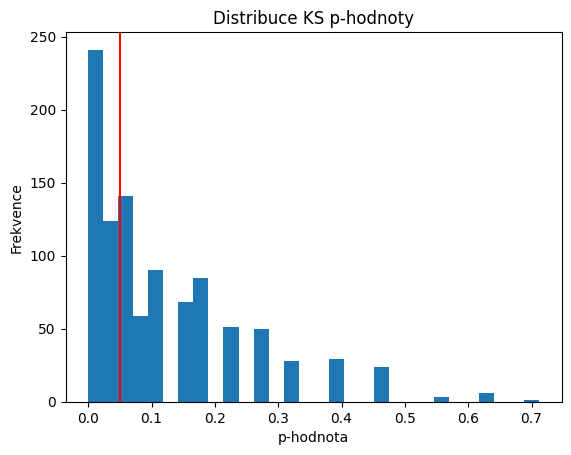

In [13]:
plt.figure()
plt.hist(p_vals, bins=30)
plt.axvline(0.05, color='red')

plt.title("Distribuce KS p-hodnoty")
plt.xlabel("p-hodnota")
plt.ylabel("Frekvence")
plt.show()

### Interpretace (DES validace)
| Podíl | Interpretace |
| ----- | -----------
|0.8 | model VALIDNÍ |
|0.5 – 0.8 | model přijatelný |
|< 0.5 | model nevalidní |

Ve 63.75 % bootstrap vzorků z kalibrace nelze statisticky rozlišit kalibraci od reality (na hladině významnosti α = 0.05 pomocí KS testu).

### Porovnání průměru a směrodatné odchylky

Reálná data – referenční hodnoty:

In [14]:
# Výpočet průměru a směrodatné odchylky z reálných dat
mean_real = real_validation_df['total_time'].mean()
std_real = real_validation_df['total_time'].std()

print("Real Mean:", mean_real)
print("Real STD:", std_real)

Real Mean: 47.24117647058823
Real STD: 32.189044537471034


Bootstrap z kalibrace (na velikost reality):

In [15]:
# velikost reálného datasetu
n_real = len(real_validation_df)

syn_means = []
syn_stds = []

# opakované podvzorkování simulace
for i in range(1000):

    sample = df_syn.sample(
        n=n_real,
        replace=True,
        random_state=122 + i
    )

    syn_means.append(sample['total_time'].mean())
    syn_stds.append(sample['total_time'].std())

### Porovnání průměru

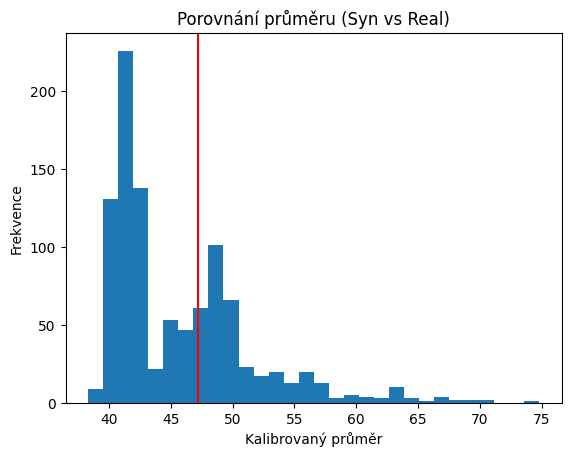

In [ ]:
# Histogram průměrů z kalibrace s vyznačením průměru reálných dat
plt.figure()

plt.hist(syn_means, bins=30)
plt.axvline(mean_real, color='red')

plt.title("Porovnání průměru (Syn vs Real)")
plt.xlabel("Průměrná doba cyklu, sek")
plt.ylabel("Frekvence")

plt.show()

### Porovnání STD

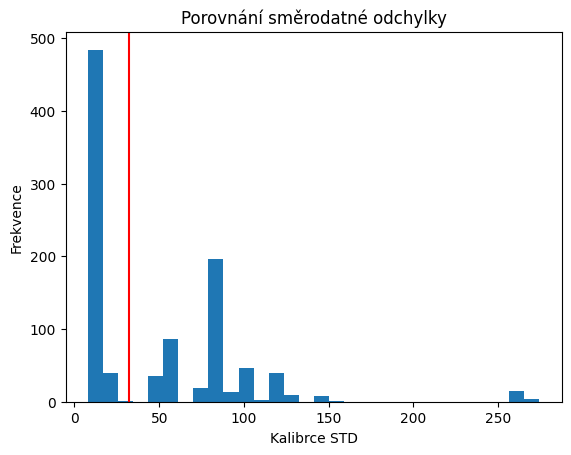

In [ ]:
# Histogram STD z kalibrace s vyznačením průměru reálných dat
plt.figure()

plt.hist(syn_stds, bins=30)
plt.axvline(std_real, color='red')

plt.title("Porovnání směrodatné odchylky")
plt.xlabel("Směrodatné odchylka")
plt.ylabel("Frekvence")

plt.show()

### Kvantilová validace

In [18]:
mean_CI = np.percentile(syn_means, [2.5, 97.5])
std_CI  = np.percentile(syn_stds, [2.5, 97.5])

print("Mean 95% CI:", mean_CI)
print("STD  95% CI:", std_CI)

print("Real mean:", mean_real)
print("Real STD:", std_real)

Mean 95% CI: [39.82693455 62.58507781]
STD  95% CI: [  8.53159402 147.00312741]
Real mean: 47.24117647058823
Real STD: 32.189044537471034


Model je validní, ale rozsah hodnot je moc široký -> **velký význam stochastichých vlivů**.

### Parametrické porovnání dat

### Welchův t-test

In [19]:
stat, p = ttest_ind(
    real_validation_df['total_time'],
    df_syn['total_time'],
    equal_var=False
)

print("Welch t-test p-value:", p)

Welch t-test p-value: 0.5404210336711416


p < 0.05 → simulace má jiný průměr.

### Cohen’s d (velikost efektu)

In [20]:
mean_diff = abs(real_validation_df['total_time'].mean() - df_syn['total_time'].mean())

pooled_std = np.sqrt(
    (real_validation_df['total_time'].std()**2 + df_syn['total_time'].std()**2) / 2
)

d = mean_diff / pooled_std

print("Cohen's d:", d)

Cohen's d: 0.0316327766224823


Cohen's d < 0.2 → zanedbatelný význam

### Neparametrické porovnání (Distribuce)

### Mann–Whitney U test

In [21]:
stat, p = mannwhitneyu(
    real_validation_df['total_time'],
    df_syn['total_time']
)

print("Mann–Whitney p-value:", p)

Mann–Whitney p-value: 0.25244267693822986


Nelze zamítnout nulovou hypotézu. Neexistuje statisticky významný rozdíl mezi mediánem reálných a simulovaných dat.

Simulace realisticky zachycuje centrální tendenci systému.

### Vyhodnocení shody simulovaných a reálných dat

********
**Bootstrap KS test**

0,722

*Interpretace*:

Ve 72.2 % případů nelze statisticky rozlišit simulaci od reality

********
**STD**

Real STD = 6.36
STD 95% CI (Sim) [4.39 ; 137.62]

*Interpretace:*

Reálná směrodatná odchylka je v intervalu, avšak simulace vykazuje nadměrnou variabilitu

*******
**Průměr**

Real Mean = 40.96
Mean 95% CI (Sim) [40.58 ; 62.98]

*Interpretace:*

Reálný průměr se nachází v intervalu simulace

********
**Welch t-test**

p = 3.63 × 10⁻⁹

*Interpretace:*

Statisticky významný rozdíl průměrů (ovlivněn rozdílnou velikostí vzorků).

********
**Cohen’s d**

0.098

*Interpretace:*

Zanedbatelný praktický rozdíl mezi průměry reálných a simulovaných dat


********
**Mann–Whitney U test (neparametrický)**

p = 0.154

*Interpretace:*

p ≫ 0,05 → nelze zamítnout nulovou hypotézu.

Nebyl prokázán statisticky významný rozdíl mezi mediány reálných a simulovaných dat (α = 0.05)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-27 | 1.1 | Vjačeslav Usmanov| added HM_02_Model_Validation.ipynb |
| 2026-02-16 | 1.2 | Vjačeslav Usmanov| changed HM_02_Model_Validation.ipynb |